In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import db
import pam
import utils as ut
import features as ft
import dtw
import clustering_evaluation as ce
import seq2seq as s2s

import time

In [2]:
DATA_PATH = "data/laurier/"
DATA_BASE = DATA_PATH + "laurier.sqlite"
SAVE_PATH = DATA_PATH + "generated_data/"
FRAME_PATH = DATA_PATH + "laurier.jpg"
VIDEO_PATH = DATA_PATH + "laurier.avi"
HOMOGRAPHY = DATA_PATH + "laurier-homography.txt"
DISTANCES = SAVE_PATH + "distances/cityblock_50.txt"

In [2]:
DATA_PATH = "data/grl/"
DATA_BASE = DATA_PATH + "grl.sqlite"
SAVE_PATH = DATA_PATH + "generated_data/"
FRAME_PATH = DATA_PATH + "grl.png"
VIDEO_PATH = DATA_PATH + "grl.MOV"
HOMOGRAPHY = DATA_PATH + "homography.txt"
DISTANCES = SAVE_PATH + "distances/cityblock_50.txt"

In [3]:
# number of best trajectories to keep for each object
nb_trajectories_per_object = 1

#trajectories ordered by object, database trajectory ids ordered by objects
trajectories_po,ids_po,nb_objects = db.get_trajectories_by_object(DATA_BASE)
trajectories_po,ids_po = db.filter_trajectories(nb_trajectories_per_object, trajectories_po, ids_po)

#total number of selected trajectories
nb_trajectories = nb_trajectories_per_object * nb_objects

# list of every selected trajectory, 
trajectories = [t for o in trajectories_po for t in o]
# ids of every selected trajectory
ids = [i for o in ids_po for i in o]
# trajectories in pixel space, for displaying purposes only
pixel_trajectories = [ut.to_pixel(t,HOMOGRAPHY) for t in trajectories]

In [4]:
velocities = [ft.compute_velocities(t) for t in trajectories]
rots = [ft.compute_ROTS(t) for t in trajectories]

pixel_points = np.array([t[0] for t in pixel_trajectories] + [t[-1] for t in pixel_trajectories])
points = np.array([t[0] for t in trajectories] + [t[-1] for t in trajectories])

x = [p[0] for p in points]
y = [p[1] for p in points]
v = [v[0] for v in velocities] + [v[-1] for v in velocities]
r = [r[0] for r in rots] + [r[-1] for r in rots]

In [5]:
import pandas as pd
data = pd.DataFrame([x,y,v,r]).T
data = data.as_matrix()

/home/laurent/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


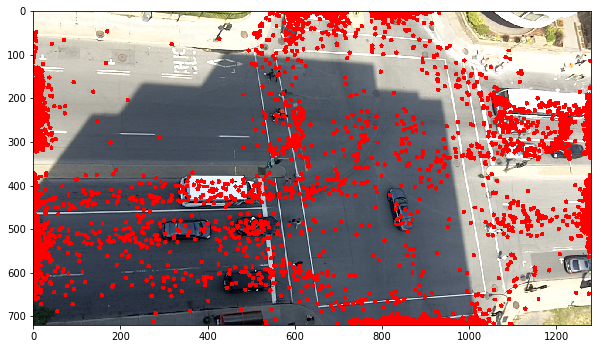

In [6]:
ut.plot_points(pixel_points,FRAME_PATH)

In [7]:
from sklearn.cluster import KMeans
algorithm = KMeans()
max_nb_clusters = 30
silhouette, _ = ce.u_clustering_eval(max_nb_clusters,algorithm,data)
ce.get_k_local_optima(np.array(silhouette),3)

[4, 15, 11]

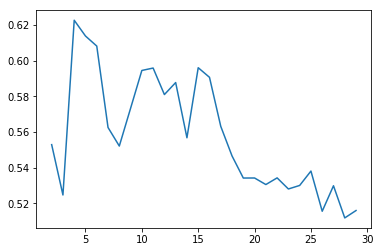

In [8]:
plt.plot(np.arange(2,max_nb_clusters,1),silhouette)

In [9]:
nb_clusters = 14

In [13]:
from sklearn.metrics import pairwise_distances
import pam
start = time.time()

distance_matrix = pairwise_distances(data,metric="manhattan")
medoids_idx, clusters =pam.pam(distance_matrix, 4)

print(time.time() - start)

583.884977102


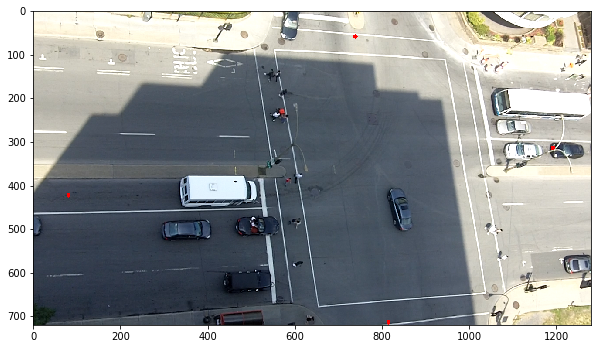

In [15]:
ut.plot_points(pixel_points[medoids_idx],FRAME_PATH)

In [33]:
clusters= KMeans(n_clusters=nb_clusters).fit_predict(data)

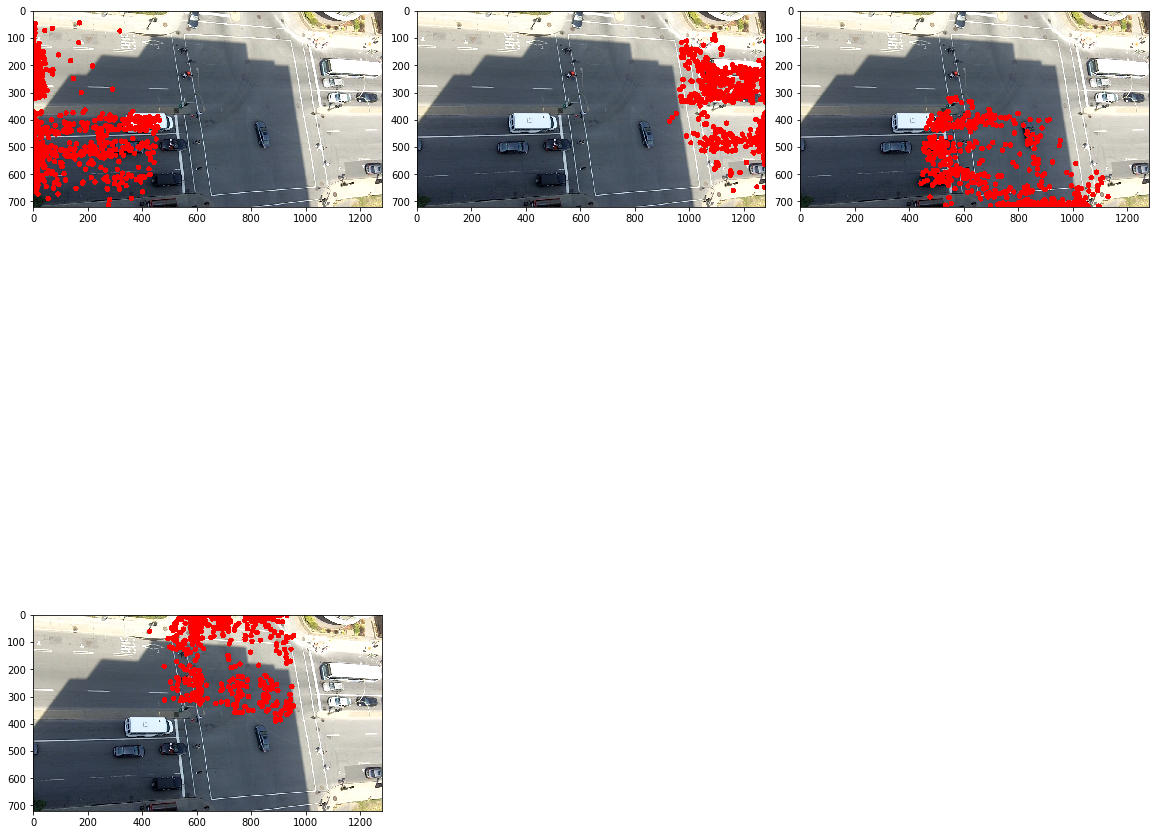

In [14]:

ut.plot_point_clusters_oat(clusters,FRAME_PATH,pixel_points)

# Classification

In [97]:
target = pd.DataFrame(clusters)
features = pd.DataFrame(data)

In [38]:
target.to_csv(SAVE_PATH + "points_targets.csv")
features.to_csv(SAVE_PATH + "points_features.csv")

In [98]:
target = target.as_matrix().reshape(-1)

/home/laurent/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [99]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)
features_pca = pca.fit_transform(features)
pca.n_components_

2

In [100]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_pca, target, test_size=0.33, random_state=42)

In [102]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(multi_class = "multinomial", solver = "newton-cg")
clf.fit(X_train,y_train)
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

In [103]:
from sklearn.metrics import log_loss,accuracy_score,f1_score,confusion_matrix
f1_score(y_train,train_pred,average = "micro")

0.9952874646559849

In [104]:
f1_score(y_test,test_pred,average = "micro")


0.9923518164435946

In [105]:
confusion_matrix(y_test,test_pred)

array([[166,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  0,  48,   0,   0,   0,   0,   1,   0,   0,   0,   0,   1,   1,
          0],
       [  0,   0, 242,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  0,   0,   0, 141,   0,   0,   0,   0,   1,   0,   0,   0,   0,
          0],
       [  0,   0,   0,   0, 113,   0,   0,   0,   1,   0,   0,   0,   0,
          0],
       [  0,   0,   1,   0,   0,  65,   1,   0,   0,   1,   0,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0, 141,   0,   0,   0,   0,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0, 206,   0,   0,   0,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  39,   0,   0,   0,   0,
          0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  74,   0,   0,   0,
          0],
       [  0,   0,   0,   2,   0,   0,   0,   0,   0,   0,  91,   0,   0,
          0],
       [  0,   1,   0,   0,   0,   0,   0, 